In [1]:
#%% Initial imports etc
import numpy
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys
import shutil

from ccpi.utilities.jupyter import *
from ccpi.utilities.display import *

#%% Use the 'pet' prefix for all STIR-based SIRF functions
# This is done here to explicitly differentiate between SIRF pet functions and 
# anything else.
import sirf.STIR as pet
from sirf.Utilities import examples_data_path

import sirf.Reg as Reg
from scipy.spatial.transform import Rotation as R
from ccpi.optimisation.operators import CompositionOperator, BlockOperator, LinearOperator

from ccpi.plugins.regularisers import FGP_TV


def add_noise(counts, sinogram):
    sino_arr = sinogram.as_array()
    minmax = (sino_arr.min(), sino_arr.max())

    counts = 300
    sino_arr = counts * (sino_arr / minmax[1])
    noisy_counts = sinogram * 0.
    noisy_counts.fill( numpy.random.poisson(sino_arr) )
    
    return noisy_counts


pet.AcquisitionData.set_storage_scheme('memory')

#%% Go to directory with input files
# Adapt this path to your situation (or start everything in the relevant directory)
os.chdir(examples_data_path('PET'))

#%% Copy files to a working folder and change directory to where these files are.
# We do this to avoid cluttering your SIRF files. This way, you can delete 
# working_folder and start from scratch.
if False:
    shutil.rmtree('working_folder/brain',True)
    shutil.copytree('brain','working_folder/brain')
os.chdir('working_folder/brain')

#%% Read in images
# Here we will read some images provided with the demo using the ImageData class.
# These are in Interfile format. (A text header pointing to a .v file with the binary data).
image = pet.ImageData('emission.hv')
mu_map = pet.ImageData('attenuation.hv')

#%% Create a SIRF acquisition model
# We will use the ray-tracing matrix here as our simple PET model.
# There is more to the accquisition model, but that's for another demo.
am = pet.AcquisitionModelUsingRayTracingMatrix()
# Ask STIR to use 5 LORs per sinogram-element
am.set_num_tangential_LORs(5)

#%% Specify sinogram dimensions
# We need to say what scanner to use, what dimensions etc.
# You do this by using existing PET data as a 'template'. 
# Here, we read a file supplied with the demo as an AcquisitionData object
templ = pet.AcquisitionData('template_sinogram.hs')
# Now set-up our acquisition model with all information that it needs about the data and image.
am.set_up(templ,image)


In [2]:
%ls
#plotter2D??

attenuation.hv
attenuation.v
emission.hv
emission.v
PDHG_0.8maxcounts_noMotion_100it_TV0.ahv
PDHG_0.8maxcounts_noMotion_100it_TV0.h
PDHG_0.8maxcounts_noMotion_100it_TV0.hv
PDHG_0.8maxcounts_noMotion_400it_TV0.ahv
PDHG_0.8maxcounts_noMotion_400it_TV0.h
PDHG_0.8maxcounts_noMotion_400it_TV0.hv
PDHG_500counts_MCIR_100it_TV05.ahv
PDHG_500counts_MCIR_100it_TV05.h
PDHG_500counts_MCIR_100it_TV05.hv
PDHG_500counts_MCIR_100it_TV0.ahv
PDHG_500counts_MCIR_100it_TV0.h
PDHG_500counts_MCIR_100it_TV0.hv
PDHG_500counts_noMCIR_100it_TV0.ahv
PDHG_500counts_noMCIR_100it_TV0.h
PDHG_500counts_noMCIR_100it_TV0.hv
PDHG_500counts_noMotion_100it_TV0.ahv
PDHG_500counts_noMotion_100it_TV0.h
PDHG_500counts_noMotion_100it_TV0.hv
PDHG_500_MCIR_100it_TV05.ahv
PDHG_500_MCIR_100it_TV05.h
PDHG_500_MCIR_100it_TV05.hv
PDHG_500_MCIR_500it_TV05.ahv
PDHG_500_MCIR_500it_TV05.h
PDHG_500_MCIR_500it_TV05.hv
PDHG_MCIR_noNoise_Motion_1000it_TV05.ahv
PDHG_MCIR_noNoise_Motion_1000it_TV05.h
PDHG_MCIR_noNoise_Motion_1000it_TV05.hv
PDH

In [ ]:
mcir_no_TV = pet.ImageData('PDHG_MCIR_noNoise_Motion_1000it_TV0.hv')
mcir_TV = pet.ImageData('PDHG_MCIR_noNoise_Motion_1000it_TV05.hv')
no_mcir = pet.ImageData('PDHG_noMCIR_noNoise_Motion_1000it_TV0.hv')
no_motion = pet.ImageData('PDHG_noMCIR_noNoise_noMotion_1000it_TV0.hv')

print (image.shape)
%matplotlib inline
plotter2D([vv.as_array()[12] for vv in [image, no_motion, mcir_no_TV, mcir_TV, no_mcir ] ] , 
          titles=['Ground Truth', 'No Motion' , 'MCIR Positivity Constraint', 'MCIR FGP TV', 'No MCIR' ] , cmap = 'inferno')



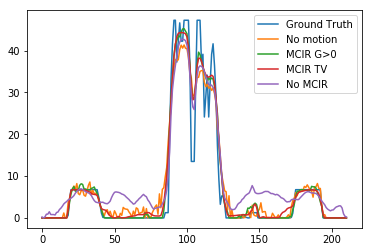

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
lines = [vv.as_array()[5][100] for vv in [image, no_motion, mcir_no_TV, mcir_TV, no_mcir ] ]
#print (lines[0])
plt.plot(lines[0], label="Ground Truth")
plt.plot(lines[1], label="No motion")
plt.plot(lines[2], label="MCIR G>0")
plt.plot(lines[3], label="MCIR TV")
plt.plot(lines[4], label="No MCIR")
plt.legend()
#plt.label('Ground Truth')
plt.show()